In [31]:
#Intel and AMD CPU Benchmarking Data Analysis
#  Nine’s Analysis -Aty
# The dataset we analyze comes from user Denis Gukov on the platform Kaggle. 
#It was compiled using a scraper to pull this data from official Intel and AMD websites.
#This dataset can be used to compare various data points between modern CPU processors.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import os
import seaborn as sns

# Import the dataset and print.
notebook_dir = os.getcwd()
benchmarks = pd.read_csv(os.path.join(notebook_dir, "cpu_benchmarks.csv"))
amd = pd.read_csv(os.path.join(notebook_dir, "amd_processors.csv"))
intel = pd.read_csv(os.path.join(notebook_dir, "intel_processors.csv"))

# Add manufacturer column before merging
amd['manufacturer'] = 'AMD'
intel['manufacturer'] = 'Intel'

# Merge both the processor datasets.
allprocessors = pd.concat([amd, intel], ignore_index=True)

# Merge the processor dataset with the benchmarks dataset using the sku value.
alldata = pd.merge(allprocessors, benchmarks, on='sku', how='inner')

# Fill missing ratings with median
alldata['rating'] = alldata['rating'].fillna(alldata['rating'].median())

# Set global style
plt.style.use('seaborn-v0_8') 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

In [40]:
#Graph #1 : AMD & Intel market by Target Usage
# This graph will help us see their dominant market. Help identify their strength and market. 

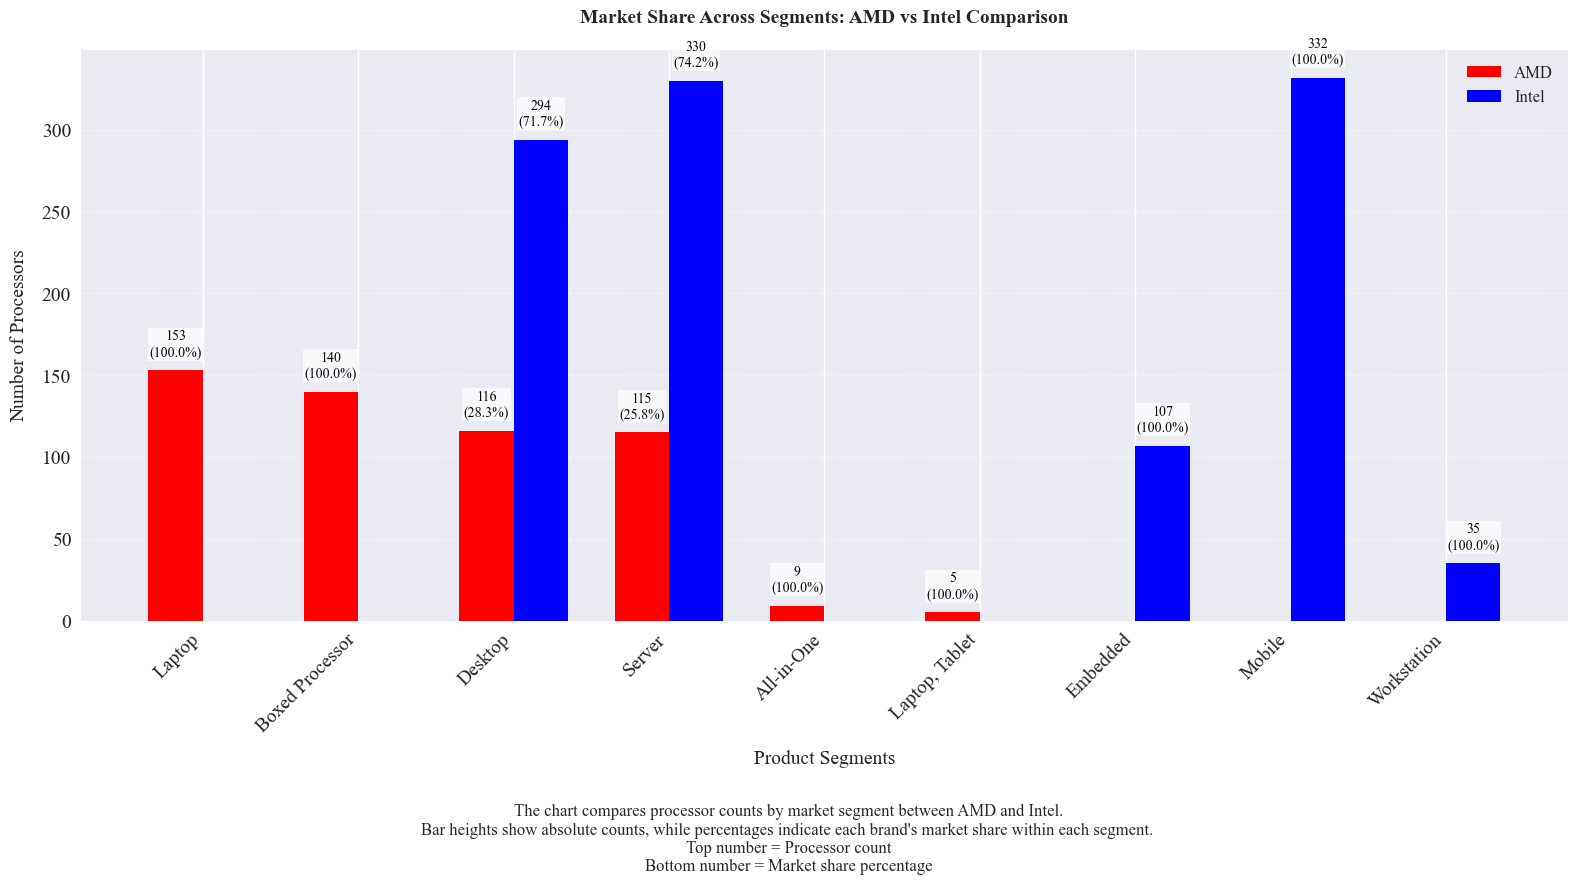

In [41]:
# Group and count processors by brand and segment
amd_sale = amd.groupby('vertical_segment')['id'].count().sort_values(ascending=False)
intel_sale = intel.groupby('vertical_segment')['id'].count().sort_values(ascending=False)

# Combine all unique segments from both brands
all_segments = amd_sale.index.union(intel_sale.index)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'AMD': amd_sale.reindex(all_segments, fill_value=0),
    'Intel': intel_sale.reindex(all_segments, fill_value=0)
}).sort_values('AMD', ascending=False)

# Calculate market share percentages (avoid division by zero)
total = plot_data['AMD'] + plot_data['Intel']
plot_data['AMD_share'] = plot_data['AMD'] / total.replace(0, 1) * 100  
plot_data['Intel_share'] = plot_data['Intel'] / total.replace(0, 1) * 100

# Create x positions for each segment
x = np.arange(len(all_segments))
width = 0.35  # Bar width

# Create the single bar graph
plt.figure(figsize=(16, 8))
amd_bars = plt.bar(x - width/2, plot_data['AMD'], width, color='red', label='AMD')
intel_bars = plt.bar(x + width/2, plot_data['Intel'], width, color='blue', label='Intel')

# Enhanced value labeling (showing both count and percentage)
def add_labels(bars, share_data=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            y_pos = height + (0.02 * plot_data[['AMD', 'Intel']].values.max())
            plt.text(bar.get_x() + bar.get_width()/2., y_pos,
                    f'{height}\n({share_data[i]:.1f}%)' if share_data is not None else f'{height}',
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

add_labels(amd_bars, plot_data['AMD_share'].values)
add_labels(intel_bars, plot_data['Intel_share'].values)

# Formatting
font_settings = {'fontname': 'Times New Roman', 'fontsize': 14}
plt.xticks(x, plot_data.index, rotation=45, ha='right', **font_settings)
plt.yticks(**font_settings)
plt.xlabel('Product Segments', labelpad=10, **font_settings)
plt.ylabel('Number of Processors', labelpad=10, **font_settings)
plt.title('Market Share Across Segments: AMD vs Intel Comparison', 
          pad=20, **font_settings)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add explanatory caption
caption = """The chart compares processor counts by market segment between AMD and Intel.
Bar heights show absolute counts, while percentages indicate each brand's market share within each segment. \nTop number = Processor count
Bottom number = Market share percentage"""
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', 
            fontsize=12, fontname='Times New Roman')
plt.savefig('Aty_Market Share .png')
plt.tight_layout()
plt.show()



In [35]:
#2 radar charts
#visualize Intel CPU performance metrics using a radar chart.
# CPU features vary widely (GHz, cores, cache size, etc.), normalization ensures fair comparison.
# Expected Insights: Intel CPU Strengths vs. Weaknesses and CPU Trends

Found 503 Intel processors


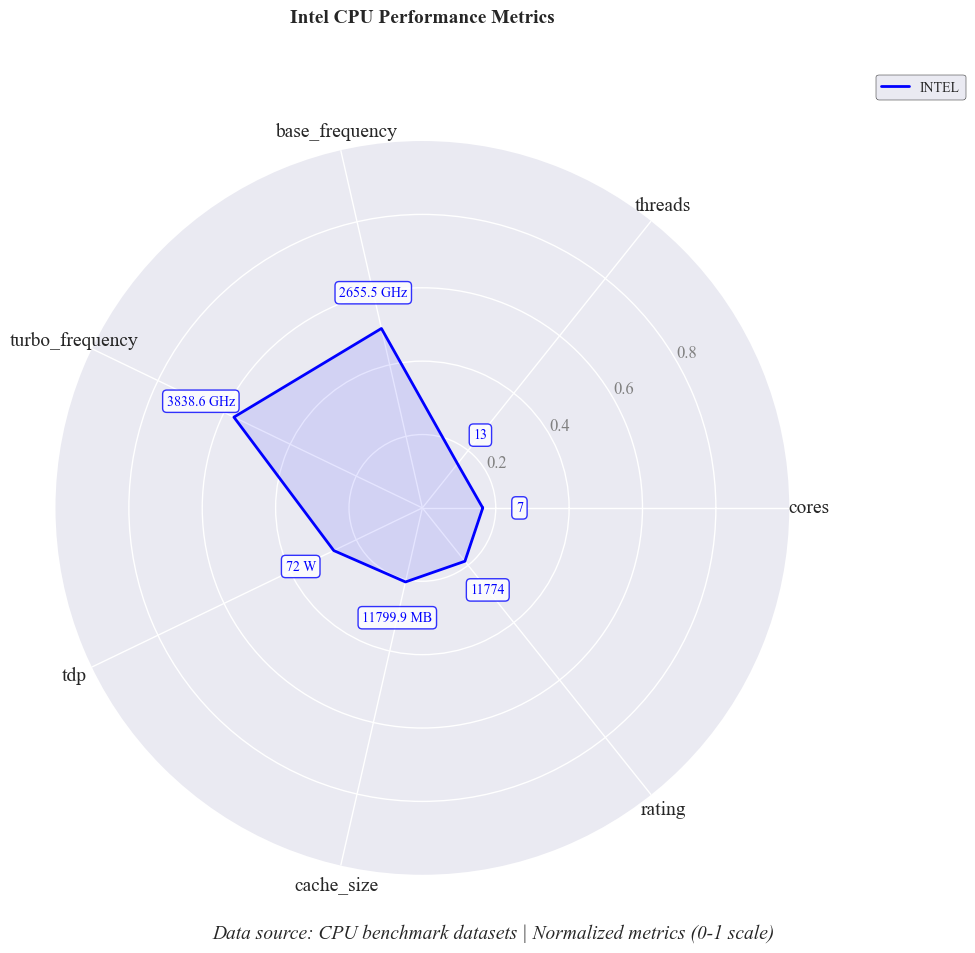

In [42]:
# Add manufacturer column if not present
if 'manufacturer' not in amd.columns:
    amd['manufacturer'] = 'AMD'
if 'manufacturer' not in intel.columns:
    intel['manufacturer'] = 'Intel'
\

# Ensure manufacturer column exists (use from benchmarks if available)
if 'manufacturer' not in alldata.columns:
    if 'manufacturer_x' in alldata.columns and 'manufacturer_y' in alldata.columns:
        alldata['manufacturer'] = alldata['manufacturer_x'].fillna(alldata['manufacturer_y'])
        alldata.drop(['manufacturer_x', 'manufacturer_y'], axis=1, inplace=True)
    elif 'manufacturer_x' in alldata.columns:
        alldata['manufacturer'] = alldata['manufacturer_x']
        alldata.drop('manufacturer_x', axis=1, inplace=True)
    elif 'manufacturer_y' in alldata.columns:
        alldata['manufacturer'] = alldata['manufacturer_y']
        alldata.drop('manufacturer_y', axis=1, inplace=True)
    else:
        # Fallback: determine manufacturer from SKU
        alldata['manufacturer'] = np.where(alldata['sku'].str.startswith('AMD'), 'AMD', 'Intel')

# Select and clean key metrics
metrics = ['cores', 'threads', 'base_frequency', 'turbo_frequency', 'tdp', 'cache_size', 'rating']
alldata = alldata.dropna(subset=metrics)

# Normalize metrics (0-1 scaling)
normalized = alldata.copy()
normalized['manufacturer'] = normalized['manufacturer'].str.lower().str.strip()

for col in metrics:
    min_val = alldata[col].min()
    max_val = alldata[col].max()
    normalized[col] = (alldata[col] - min_val) / (max_val - min_val)
    normalized[f'{col}_raw'] = alldata[col]  # Keep original values

def create_radar_chart(df, title):
    categories = metrics
    N = len(categories)
    
    # Calculate angles for radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the circle
    
    # Initialize plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Configure axis
    plt.xticks(angles[:-1], categories, fontsize=14)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=12)
    plt.ylim(0, 1)
    
    # Plot data for Intel only
    manufacturer = 'intel'
    color = 'blue'
    mfg_data = df[df['manufacturer'] == manufacturer]
    
    if not mfg_data.empty:
        print(f"Found {len(mfg_data)} Intel processors")
        
        # Calculate average normalized values
        avg_norm = mfg_data[metrics].mean().tolist()
        avg_norm += avg_norm[:1]
        
        # Get average raw values for annotation
        avg_raw = mfg_data[[f'{col}_raw' for col in metrics]].mean().tolist()
        avg_raw += avg_raw[:1]
        
        # Plot the line
        ax.plot(angles, avg_norm, linewidth=2, linestyle='solid', 
                label=manufacturer.upper(), color=color)
        
        # Fill the area
        ax.fill(angles, avg_norm, alpha=0.1, color=color)
        
        # Add data point annotations
        for i, (angle, norm_val, raw_val) in enumerate(zip(angles[:-1], avg_norm[:-1], avg_raw[:-1])):
            # Format values based on metric type
            if 'frequency' in categories[i]:
                val_str = f"{raw_val:.1f} GHz"
            elif 'cache' in categories[i]:
                val_str = f"{raw_val:.1f} MB"
            elif 'tdp' in categories[i]:
                val_str = f"{raw_val:.0f} W"
            elif 'rating' in categories[i]:
                val_str = f"{raw_val:.0f}"
            else:
                val_str = f"{raw_val:.0f}"
            
            # Position annotations slightly outside the plot
            ax.annotate(val_str, 
                       xy=(angle, norm_val + 0.05),
                       xytext=(angle, norm_val + 0.1),
                       ha='center', va='center',
                       fontsize=10, color=color,
                       bbox=dict(boxstyle='round,pad=0.3', 
                                fc='white', ec=color, lw=1, alpha=0.8))
    else:
        print(f"Warning: No data found for Intel")

    # Add title and legend
    plt.title(title, size=14, y=1.15, fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), 
              frameon=True, framealpha=1, edgecolor='black')
    
    # Add data source footnote
    plt.figtext(0.5, 0.01, "Data source: CPU benchmark datasets | Normalized metrics (0-1 scale)", 
               ha="center", fontsize=14, style='italic')
    plt.savefig('Aty_Intel CPU Performance Metrics .png')
    plt.tight_layout()
    plt.show()

# Generate the visualization
create_radar_chart(normalized, "Intel CPU Performance Metrics")
intel['sku'] = intel['sku'].astype(str).str.strip()

In [43]:
##"CPU Architecture Tradeoffs: Cores vs. Clock Speed"
#Enhanced bubble plot with regression lines and dual axes
#Bubble size: Benchmark rating (larger = better performance)
#This visualization reveals the fundamental design trade-offs between AMD and Intel CPU

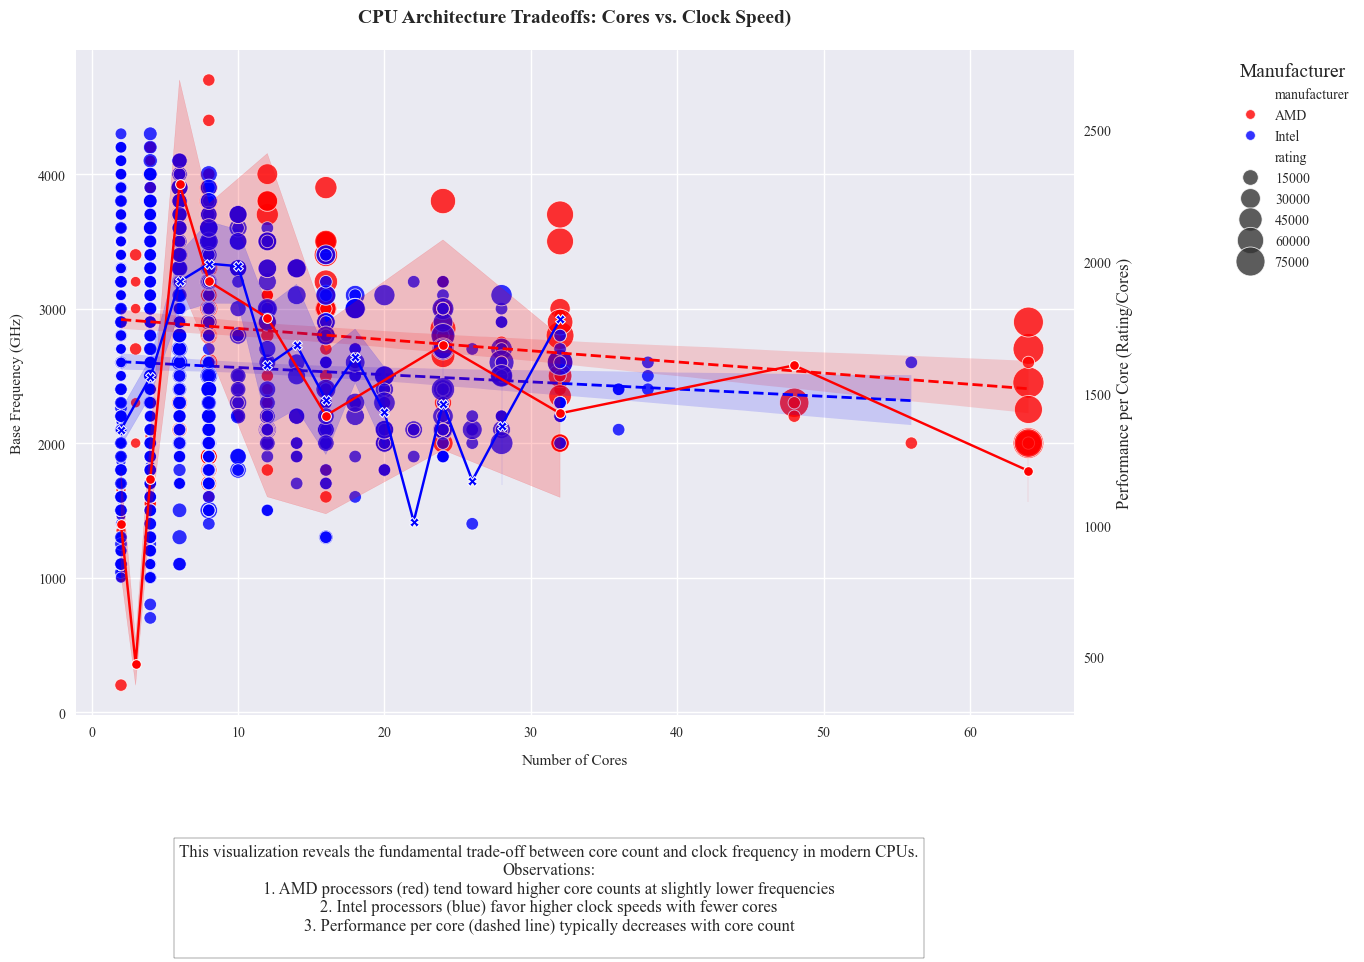

In [50]:
# DATA PREPARATION
def clean_frequency(freq):
    """Convert frequency strings to numeric values with error handling"""
    try:
        if isinstance(freq, str):
            return float(freq.replace('GHz', '').strip())
        return float(freq)
    except (ValueError, TypeError):
        return np.nan

# Clean and standardize AMD data
amd_clean = amd.copy()
amd_clean['base_frequency'] = amd_clean['base_frequency'].apply(clean_frequency)
amd_clean['cores'] = pd.to_numeric(amd_clean['cores'], errors='coerce')
amd_clean['manufacturer'] = 'AMD'
amd_clean['sku'] = amd_clean['sku'].astype(str).str.strip()

# Clean and standardize Intel data
intel_clean = intel.copy()
intel_clean['manufacturer'] = 'Intel'
intel_clean['sku'] = intel_clean['sku'].astype(str).str.strip()

# Handle column name variations
if 'base_clock' in intel_clean.columns:
    intel_clean['base_frequency'] = intel_clean['base_clock'].apply(clean_frequency)

#DATA MERGING
all_processors = pd.concat([amd_clean, intel_clean]).reset_index(drop=True)

# Standardize benchmark data
benchmarks['sku'] = benchmarks['sku'].astype(str).str.strip()
benchmarks['rating'] = pd.to_numeric(benchmarks['rating'], errors='coerce')

# Now merge with benchmarks
merged = pd.merge(all_processors, benchmarks, 
                 on='sku', 
                 how='left',
                 suffixes=('', '_benchmark'))

#DERIVED METRICS
# Calculate performance per core (derived metric)
merged['rating_per_core'] = merged['rating'] / merged['cores']

# Calculate frequency boost ratio (derived metric)
merged['boost_ratio'] = merged['turbo_frequency'] / merged['base_frequency']

# Fill missing values
merged['rating'] = merged.groupby('manufacturer', group_keys=False)['rating'].apply(
    lambda x: x.fillna(x.median()))

# VISUALIZATION
fig, ax = plt.subplots(figsize=(14, 8))

# Filter valid data points
plot_data = merged.dropna(subset=['cores', 'base_frequency', 'rating', 'manufacturer'])

# Create bubble plot with enhanced annotations
scatter = sns.scatterplot(
    data=plot_data,
    x='cores',
    y='base_frequency',
    size='rating',
    hue='manufacturer',
    sizes=(50, 500),
    alpha=0.8,
    palette={'AMD': 'red', 'Intel': 'blue'},
    ax=ax
)


# Add trendlines with equation annotations
for manufacturer, color in [('AMD', 'red'), ('Intel', 'blue')]:
    subset = plot_data[plot_data['manufacturer'] == manufacturer]
    if len(subset) >= 2:
        sns.regplot(
            data=subset,
            x='cores',
            y='base_frequency',
            scatter=False,
            color=color,
            line_kws={'linestyle': '--', 'label': f'{manufacturer} Trend', 'linewidth': 2},
            ax=ax
        )

# Add derived metric visualization (performance per core)
ax2 = ax.twinx()
sns.lineplot(
    data=plot_data,
    x='cores',
    y='rating_per_core',
    hue='manufacturer',
    style='manufacturer',
    markers=True,
    dashes=False,
    palette={'AMD': 'red', 'Intel': 'blue'},
    legend=False,
    ax=ax2
)
ax2.set_ylabel('Performance per Core (Rating/Cores)', fontsize=12)
ax2.grid(False)

# Finalize plot
ax.set_title('CPU Architecture Tradeoffs: Cores vs. Clock Speed)', pad=20)
ax.set_xlabel('Number of Cores', labelpad=10)
ax.set_ylabel('Base Frequency (GHz)', labelpad=10)
ax.legend(title='Manufacturer', bbox_to_anchor=(1.15, 1), loc='upper left')

# Add explanatory caption
plt.figtext(
    0.4, -0.2,
    "This visualization reveals the fundamental trade-off between core count and clock frequency in modern CPUs.\n"
    "Observations:\n"
    "1. AMD processors (red) tend toward higher core counts at slightly lower frequencies\n"
    "2. Intel processors (blue) favor higher clock speeds with fewer cores\n"
    "3. Performance per core (dashed line) typically decreases with core count\n",
    ha='center',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('CPU_Architecture_Tradeoffs.png', bbox_inches='tight', dpi=300)
plt.show()